# Chapter 3: Classification

---

## Introduction


Chapter 3 focuses on **Classification**, a core machine learning task where models categorize data into predefined labels. It covers essential concepts like binary and multiclass classification, performance metrics (precision, recall, F1-score, ROC curves), and practical strategies for addressing challenges such as class imbalance and overfitting. Additionally, it explores hyperparameter tuning techniques to optimize classifier performance. This chapter blends theoretical insights with hands-on examples, equipping readers to build and evaluate robust classification models effectively.

---

## MNIST Dataset

**In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.**

In [1]:
# Sklearn does provide mnsit dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# Specifying data and labels
X, y = mnist['data'], mnist['target']

# Overview on data structure
print("Data Dimensions:", X.shape)
y.shape

Data Dimensions: (70000, 784)


(70000,)

In [3]:
"""There are 70,000 images, and each image has 784 features. This is because
each image is 28 x 28 pixels, and each feature simply represents one
pixel's intensity, from 0 (white) to 255 (black)."""

# overview on data by reviewing a sample
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

Pretty look like five


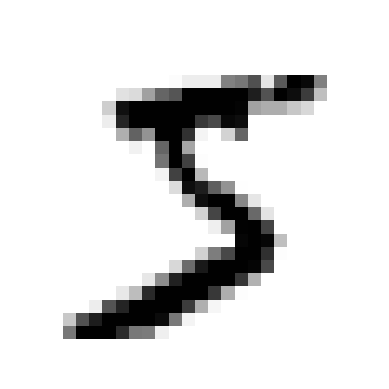

digit label:  5


In [4]:
# plot the digit
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
print("Pretty look like five")
plt.show()
print("digit label: ", y[0])

In [5]:
# Note that the label is a string. Most ML algorithms expect numbers, so
# cast y to integer
import numpy as np
y = y.astype(np.uint8)

In [6]:
# Splitting data ---> Train & Test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Now a piece of luck that training data is shuffled and all k-fold will be similar 

---

## Training a Binary Classifier

Training a binary classifier that detects 5 and non-5 numbers

In [7]:
# True for all 5s, False for all non-5s
y_train_five = (y_train == 5)
y_test_five = (y_test == 5)

In [8]:
# Training Stochastic Gradient Descent class from sklearn
# The SGDClassifier relies on randomness during training (hence the name “stochastic”).
# If you want reproducible results, you should set the random_state parameter.
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_five) 

SGDClassifier(random_state=42)

In [9]:
# test some digit
sgd_clf.predict([some_digit])

array([ True])

---

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating regressor, so we will spend a large part of this chapter on this topic.

### Measuring Accuracy Using Cross-Validation

Since we need more control on cross validation than the one sklearn provide so we will implement it, And Notice that we are training every index alone which made this process suitable also for online learning

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
def crafted_cross_val_score(train_set, labels_set):
    result = []
    skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_index, test_index in skfolds.split(train_set, labels_set):
        clone_clf = clone(sgd_clf)
        train_train_fold = train_set[train_index]
        label_train_fold = labels_set[train_index]
        train_test_fold = train_set[test_index]
        label_test_fold = labels_set[test_index]
        
        clone_clf.fit(train_train_fold, label_train_fold)
        label_pred = clone_clf.predict(train_test_fold)
        n_correct = sum(label_pred == label_test_fold)
        
        result.append(n_correct / len(label_pred))
    return result

print(crafted_cross_val_score(X_train, y_train_five))

[np.float64(0.9669), np.float64(0.91625), np.float64(0.96785)]


In [11]:
# cross validation method behavior
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_five,
                scoring='accuracy' , cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# defining a dumb classifier for testing its behavior
from sklearn.base import BaseEstimator
class non_five_classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
# non_five_classifier score
non_five_clf = non_five_classifier()
cross_val_score(non_five_clf, X_train, y_train_five,
                scoring='accuracy', cv=3)

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

In [14]:
# first we need a set of predictions to compare it with the target actual values
from sklearn.model_selection import cross_val_predict
sgd_clf_preds = cross_val_predict(sgd_clf, X_train, y_train_five, cv=3)

**By using *cross_val_predict()* you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).** since it performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [15]:
# Measuring with confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_five, sgd_clf_preds)

array([[53892,   687],
       [ 1891,  3530]])

### An interesting one to look at is the accuracy of the positive predictions; this is called the **precision** of the classifier

***precision** = TP / (TP + FP)* , when: <br>
* TP -> True Positives
* FP -> False Positives

Precision usually associated with another metric called recall or sensitivity

***recall (sensitivity)** = TP / (TP + FN)* , when: <br>
* FN -> False Negatives

Sklearn does provide these metrics

In [16]:
from sklearn.metrics import precision_score , recall_score
precision_score(y_train_five, sgd_clf_preds)

np.float64(0.8370879772350012)

In [17]:
recall_score(y_train_five, sgd_clf_preds)

np.float64(0.6511713705958311)

A common practice is to combine those two metrics in one metric called **F1 score**, Which is a harmonic mean of the two metrics

So ***F1 score**= 2 / ((1/precision) + (1/recall)) = precision x recall/(recall + precision) = **TP/(TP + (FN + FB)/2)***

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_five, sgd_clf_preds)

np.float64(0.7325171197343847)

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the ***precision/recall trade-off.***

### Precision/Recall Trade-off

Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_five,
                             method='decision_function', cv=3)

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_five, y_scores)

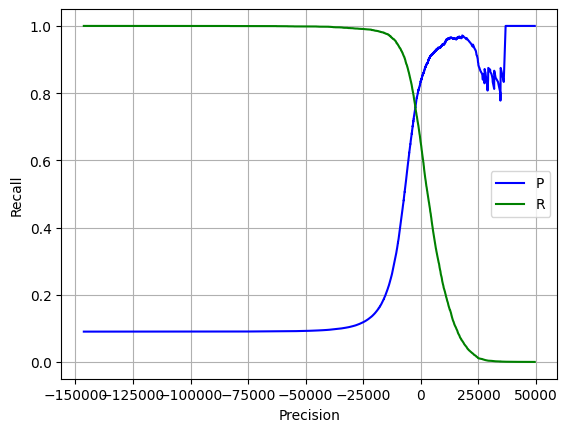

In [20]:
# defining plot function
def plot_precisions_recalls_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.legend('PR')
    plt.grid(True)
plot_precisions_recalls_vs_thresholds(precisions, recalls, thresholds)
plt.show()

In [21]:
# for determining what threshold gives me 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_five, y_train_pred_90)

np.float64(0.9000345901072293)

In [22]:
recall_score(y_train_five, y_train_pred_90)

np.float64(0.4799852425751706)

Now you can see that we can generate a classifier with any precision we wnat but at what cost (recall gets too low !!!)

### The ROC *(Receiver Operating Characteristic)* Curve

Is another tool used like precision/recall trade off , but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

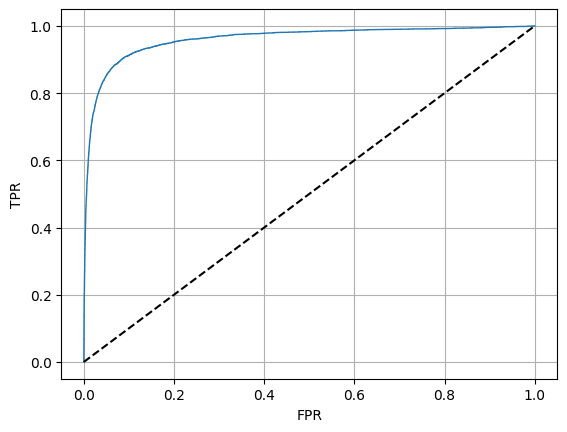

In [23]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_five, y_scores)

# define the plot function
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=1, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr)
plt.show()

In [24]:
# calculate the area under the curve instead
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_five, y_scores)

np.float64(0.9604938554008616)

Since we care more about false positives more than false negative tending to be more preciece, We prefer using PR curve more than ROC curve 

In [25]:
# training a random_forset classifier to measure its behavior with ROC metric
from sklearn.ensemble import RandomForestClassifier
frst_clf = RandomForestClassifier(random_state=42, n_estimators=100)
frst_y_probs = cross_val_predict(frst_clf, X_train, y_train_five,
                                 method="predict_proba", cv=3)

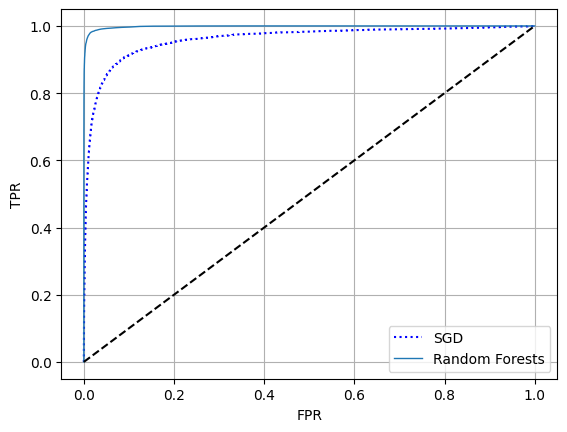

In [26]:
# using positive class probablilities
frst_y_pos_probs = frst_y_probs[:, 1]
fpr_frst, tpr_frst, thresholds = roc_curve(y_train_five, frst_y_pos_probs)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_frst, tpr_frst, "Random Forests")
plt.legend(loc="lower right")
plt.show()

**We can notice that ROC has really been beneficial to us since we can clearly see that Random Forest Classifier shows better results than Stochastic Gradient Descent**

---

## Multiclass Classification

**there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.**

1. **OvR strategey** <br>
one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to lassify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called oneversus- all).

2. **OvO strategy** <br> 
second strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train **N × (N – 1) / 2** classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

In [27]:
# testing with SVMs
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Here SVM secretly runs a OvO and measures the winning dual 

In [28]:
# here you can see that class 5 has won with the highest score
some_digit_scores = svm_clf.decision_function([some_digit])
print("Classes indices: ", svm_clf.classes_)
print("Class score: ", some_digit_scores)
print("Highest calss score index: ", np.argmax(some_digit_scores))

Classes indices:  [0 1 2 3 4 5 6 7 8 9]
Class score:  [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Highest calss score index:  5


In [29]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [30]:
# SGD classifier does not really use OvO or OvR
sgd_clf.decision_function([some_digit]) 

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [31]:
# validating the classifier
cross_val_score(sgd_clf, X_train, y_train, 
                scoring='accuracy', cv=3)

array([0.87365, 0.85835, 0.8689 ])

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, 
                scoring='accuracy', cv=3)

array([0.87365, 0.85835, 0.8689 ])

---

## Error Analysis

You may think after exploring data preparation options, try out multiple models (shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV), and automate as much as possible that there no way i can optimize more than this but acually there is, you can analyze the types of errors model makes

In [33]:
# By using condusion matrix to look in depth in the classification error
y_train_preds = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
confs_mx = confusion_matrix(y_train, y_train_preds)
confs_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

A lot of numbers!!, For simplification we can use Matplotlib 

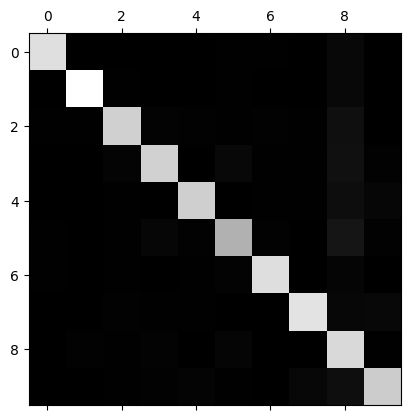

In [34]:
# visual representation for confusion matrix
plt.matshow(confs_mx, cmap=plt.cm.gray)
plt.show()

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case

In [35]:
# Firstly, we need to know every category percentage in its row
rows_sum = confs_mx.sum(axis=1, keepdims=True)
norm_confs_mx = confs_mx / rows_sum

Since the main diagonal has the true values and we need to invastigate the error only we zeros the main diagonal

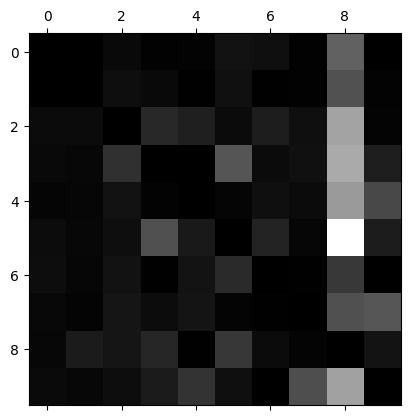

In [36]:
# Focusing on error ---> Zeros true values
np.fill_diagonal(norm_confs_mx, 0)
plt.matshow(norm_confs_mx, cmap=plt.cm.gray)
plt.show()

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. **For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit- Image, Pillow, or OpenCV) to make some patterns, such as closed loops**, stand out more.

In [37]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

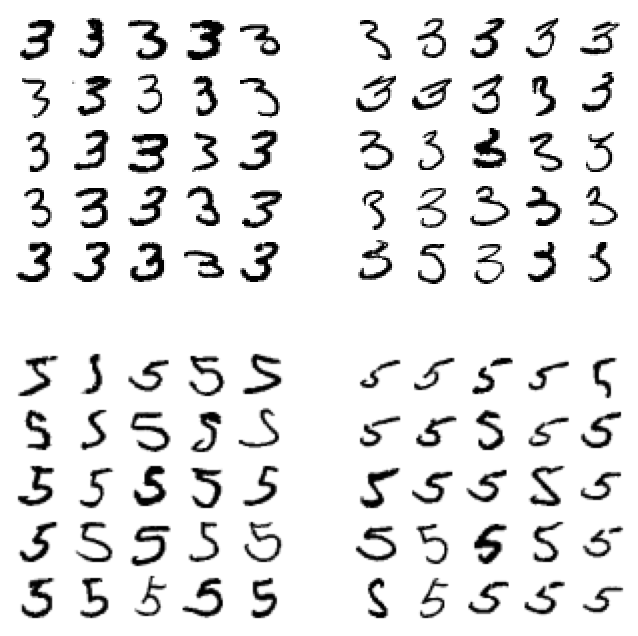

In [38]:
# We can also analyze errors manually and individually
# Invastigating numbers that get confused
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_preds == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_preds== cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_preds == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_preds == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

So we can see that classifier do misclassified 3 and 5 since the main differenc in writing in the top line joining the below arc which some images does not write this well <br>
**Notice also that we are using simple classifier *SGDClassifier* which uses classfying system based on linear summed wights**

---

## Multilabel Classification

A classifier that recognize multiple labels in the one picture is called **Multilabel Classifier** Since it outputs multiple classes for each instance

In [39]:
# Simple example for multilabel classification
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [40]:
# test it
KNN_clf.predict([some_digit])

array([[False,  True]])

We notice that this time we outed two values

In [42]:
# measuring the classifier efficiency
y_train_knn_preds = cross_val_predict(KNN_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_preds, average='macro')

np.float64(0.9764102655606048)

---

## Multiout Classification

To illustrate this, let’s build a system that removes noise from images. It
will take as input a noisy digit image, and it will (hopefully) output a clean
digit image, represented as an array of pixel intensities, just like the
MNIST images. Notice that the classifier’s output is multilabel (one label
per pixel) and each label can have multiple values (pixel intensity ranges
from 0 to 255). It is thus an example of a multioutput classification
system.
NOTE

In [43]:
# adding noice to images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

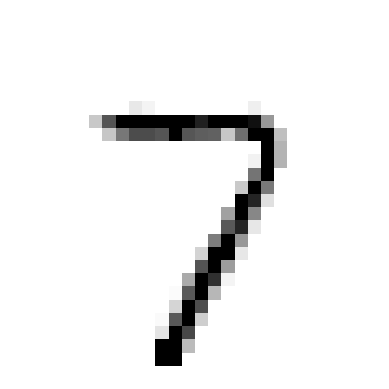

In [45]:
# training the model with cleaned images
KNN_clf.fit(X_train_mod, y_train_mod)
clean_digit = KNN_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)

### Last but not least
You should now know how to select good metrics for classification tasks,
pick the appropriate precision/recall trade-off, compare classifiers, and
more generally build good classification systems for a variety of tasks.

---

## Conclusion

Chapter 3 of Hands-On Machine Learning provides a foundational understanding of end-to-end machine learning workflows, emphasizing the importance of data preprocessing, feature scaling, and pipeline construction. It bridges the gap between theory and practical implementation, offering actionable insights into handling real-world data complexities.

By applying these concepts, we can build robust models that are efficient, scalable, and ready for deployment. The tools and techniques explored in this chapter, especially the use of pipelines, not only streamline the development process but also enhance reproducibility and collaboration.

This chapter serves as a stepping stone toward mastering machine learning, reinforcing that success in this domain lies in the synergy between clean data, sound preprocessing, and iterative experimentation.